In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "y",
          "axes.facecolor" : "None",
          "text.color" : 'w'}
plt.rcParams.update(params)

try:
  from google.colab import drive
  drive.mount('/content/drive')
  PATH_DATASET = '/content/drive/My Drive/Colab Notebooks/coffee_net/'
except:
  PATH_DATASET = ''

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory= PATH_DATASET+'data/',
    labels='inferred',
    label_mode='int', 
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training"
)


Found 1813 files belonging to 2 classes.
Using 1451 files for training.


In [10]:

type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory= PATH_DATASET+'data/',
    labels='inferred',
    label_mode='int', 
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 1813 files belonging to 2 classes.
Using 362 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['bad', 'good']


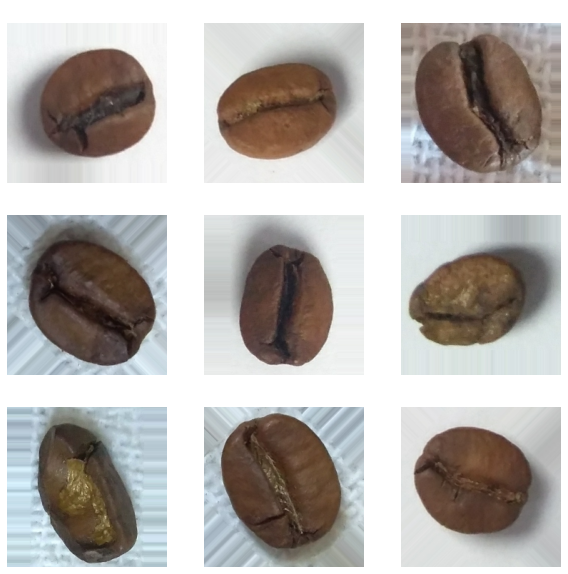

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.044140495 0.94611174


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224,3))

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [ ]:
feature_extractor.trainable = False

In [ ]:
def coffee_block(input_tensor, n_filters, activation='relu', block_name="1", reg_val = 1e-4):
    conv1 = tf.keras.layers.Conv2D(filters=n_filters, 
                                 kernel_size=(3, 3), 
                                 strides=(1, 1), 
                                 padding='same', 
                                 activation=activation,
                                 kernel_regularizer=tf.keras.regularizers.L1L2(l1=reg_val, l2=reg_val),
                                 bias_regularizer=tf.keras.regularizers.L1L2(l1=reg_val, l2=reg_val),
                                 name="Conv1_{}".format(block_name))(input_tensor)
    conv2 = tf.keras.layers.Conv2D(filters=n_filters, 
                                  kernel_size=(3, 3), 
                                  strides=(1, 1), 
                                  padding='same', 
                                  activation=activation,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(l1=reg_val, l2=reg_val),
                                  bias_regularizer=tf.keras.regularizers.L1L2(l1=reg_val, l2=reg_val),
                                  name="Conv2_{}".format(block_name))(input_tensor)
    residual = tf.keras.layers.Concatenate(name="concat_{}".format(block_name))([conv1, conv2])
    batch_norm = tf.keras.layers.BatchNormalization(name="batch_norm_{}".format(block_name))(residual)
    activation = tf.keras.layers.Activation(activation='relu')(batch_norm)
    max_pool = tf.keras.layers.MaxPool2D(pool_size=(2, 2), name="max_pool_{}".format(block_name))(activation)
    return max_pool

In [ ]:
reg_val = 1e-4
input_tensor = tf.keras.layers.Input(shape=(224,224,3), name="input_tensor")
block_1 = coffee_block(input_tensor=input_tensor, n_filters=32, block_name="1", activation=None)
block_2 = coffee_block(input_tensor=block_1, n_filters=32, block_name="2", activation=None)
block_3 = coffee_block(input_tensor=block_2, n_filters=32, block_name="3", activation=None)
block_4 = coffee_block(input_tensor=block_3, n_filters=64, block_name="4", activation=None)
block_5 = coffee_block(input_tensor=block_4, n_filters=64, block_name="5", activation=None)

global_max_pool = tf.keras.layers.GlobalMaxPooling2D(name="global_max_pool")(block_5)
dropout = tf.keras.layers.Dropout(rate=0.5, name="Dropout")(global_max_pool)
fc1 = tf.keras.layers.Dense(64,
                            activation=None,
                            kernel_regularizer=tf.keras.regularizers.l2(l=reg_val),
                            bias_regularizer=tf.keras.regularizers.l2(l=reg_val),
                            name="head_dense_1")(dropout)
head = tf.keras.layers.BatchNormalization(name="batch_norm")(fc1)
head = tf.keras.layers.Activation(activation="relu")(head)
fc2 = tf.keras.layers.Dense(2, activation='softmax', name='target')(head)
model = tf.keras.Model(inputs=input_tensor, outputs=fc2)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tensor (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_1 (Conv2D)                (None, 224, 224, 32) 896         input_tensor[0][0]               
__________________________________________________________________________________________________
Conv2_1 (Conv2D)                (None, 224, 224, 32) 896         input_tensor[0][0]               
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, 224, 224, 64) 0           Conv1_1[0][0]                    
                                                                 Conv2_1[0][0]         

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

Epoch 1/6
46/46 [==============================] - 533s 12s/step - loss: 1.6189 - accuracy: 0.7147 - val_loss: 1.8637 - val_accuracy: 0.2514

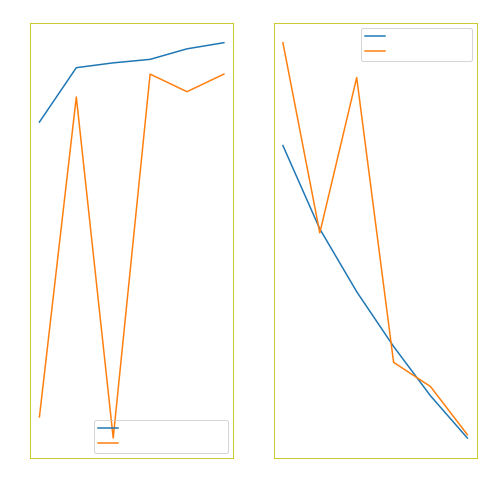

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
class_names = np.array(class_names)

In [ ]:
image_batch, label_batch = next(iter(train_ds.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_ids = predicted_ids.astype(int)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good'],
      dtype='<U4')

In [ ]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
Predicted labels:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


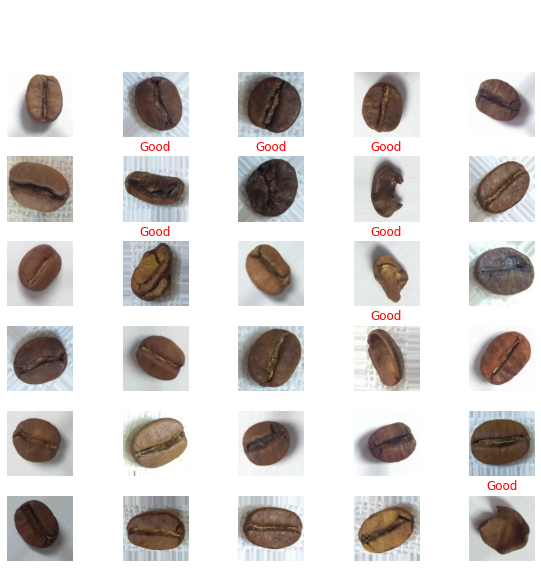

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n].astype(np.uint8))
  color = "white" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")